In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings
import itertools

from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Embedding, Bidirectional, concatenate, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 150
ec = LabelEncoder() # encode the categorical status
sc = StandardScaler() # scale the whole dataset to make the model learn faster

class alarm_statename_LSTM:
    def __init__(self, eq_id, lookback_window, alarm_table):
        self.eq_id = eq_id
        self.lookback_window = lookback_window
        self.alarm_table = alarm_table
        self.status_table = self.query_status()
        self.important_state_name = ["Break down Maintenance", "Utility Problem", "Maintenance", "IT Problem", \
                                    "Waiting For Spares", "MOTOR ERROR", "Half Yearly PM", "IT Maintenance", \
                                    "Machine Failure", "HANG UP", "Waiting For Repair", "BAD WEDGE FORM", "INDEXER PROBLEM",\
                                    "PC Buyoff Failed", "SHORT TAIL", "WIRE BREAK"]
        
        # make sure that the timeframe table is a subset of both the alarm and status table to compute major down correctly
        time1 = self.alarm_table.iloc[0]["DT_SET"]
        time2 = self.status_table.iloc[0]["TIMESTAMP_START"]
        timeend1 = self.alarm_table.iloc[len(self.alarm_table)-1]["DT_SET"]
        timeend2 = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"]
        
        start = (max(time1, time2) + timedelta(days=3)).strftime("%d/%m/%Y") # give a 3 days window to ensure that the alarm would have 60 records as well
        end = min(timeend1, timeend2).strftime("%d/%m/%Y")
        
        self.timeframe_table = self.generate_time(start, end, 3)
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, 6, 3600)
        self.statename_seq, self.statename_dur, self.alarm_seq = self.sequence_input(self.timeframe_table, self.alarm_table, self.status_table)
    
    
    def generate_time(self, start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])
        
    def query_status(self):
        try:
            oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
            engine = create_engine(
                oracle_string.format(
                    username = 'TFM4CEBERUS',
                    password = 'TFM4CEBERUS',
                    hostname = 'ome-db.bth.infineon.com',
                    port = '1538',
                    database = 'ome'
                    )
                )
        except Exception as e:
            print(str(e))

        query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
                from (SELECT
                  eq.eq_id, eq.name, eq.eq_type_ident
                , data.timestamp_start,data.timestamp_end
                , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                , level5s.state_name
                , level5.state_name Level5_Name, level5.state_sign Level5
                , level4.state_name Level4_Name, level4.state_sign Level4
                , level3.state_name Level3_Name, level3.state_sign Level3
                ,mh.device
                ,mh.package,
                mh.lotid as lot,
                mh.product,
                mh.operation

                FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                , OMEADMIN.EQUIPMENT_INSTANCES eq
                , V_EQ_STATES level5s
                , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                , OMEDATA.METAKEY_HISTORY mh

                WHERE data.eq_ident  = eq.eq_ident
                AND  data.eq_status = level5s.state_ident(+)
                AND level5.state_ident = data.tr25_5_status
                AND level4.state_ident = data.tr25_4_status
                AND level3.state_ident = data.tr25_3_status
                AND  data.metakey_ident =mh.ident(+)
                and data.timestamp_start > sysdate - 1500)
                where eq_id = '{self.eq_id}'
                ORDER BY TIMESTAMP_START"""

        status = pd.read_sql(query, engine)
        status.columns = map(lambda x: str(x).upper(), status.columns) 

        return status
    
    def sequence_input(self, timeframe_table, alarm_table, status_table):
        if (timeframe_table.iloc[0]["TIMESTAMP"] < alarm_table.iloc[0]["DT_SET"]) or \
        (timeframe_table.iloc[0]["TIMESTAMP"] < status_table.iloc[0]["TIMESTAMP_START"]):
            raise Exception("Timeframe table must be a subset of both the alarm of status table")
        
        if (timeframe_table.iloc[len(timeframe_table)-1]["TIMESTAMP"] > alarm_table.iloc[len(alarm_table)-1]["DT_SET"]) or \
        (timeframe_table.iloc[len(timeframe_table)-1]["TIMESTAMP"] > status_table.iloc[len(status_table)-1]["TIMESTAMP_START"]):
            raise Exception("Timeframe table must be a subset of both the alarm of status table")

        alarm_seq = []
        alarm_dur = []
        statename_seq = [] 
        statename_dur = []
        for idx, row in timeframe_table.iterrows():
            end = row["TIMESTAMP"]
            start = end - timedelta(hours=self.lookback_window)
            filtered_table_status = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & \
                                                     (status_table["TIMESTAMP_START"] <= end) & \
                                                     (status_table.STATE_NAME.isin(self.important_state_name))]
            filtered_alarm = alarm_table.loc[(alarm_table["DT_SET"]>=start) & (alarm_table["DT_SET"]<=end)]

            statename_seq.append(np.array(filtered_table_status["STATE_NAME"].values))
            statename_dur.append(np.array(filtered_table_status["DURATION"].values).astype(int))
            alarm_seq.append(np.array(filtered_alarm["Alarm ID"].values))

        return np.array(statename_seq), np.array(statename_dur), np.array(alarm_seq)
    
    def major_down(self, input_df, status_table, hour, threshold):
            hour = pd.Timedelta(hours=hour)
            major_down = []

            for idx, row in input_df.iterrows():
                start = row['TIMESTAMP']
                end = start+hour
                frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
                UD = frame.loc[frame['LEVEL3']=='UDT']

                if len(UD) == 0: #no record within this 6 hours:
                    major_down.append(0)
                else:
                    time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                    if any(time_diff>threshold):
                        major_down.append(1)
                    else:
                        major_down.append(0)
            return major_down
    
    def preprocess_data(self, statename_seq, statename_dur, alarm_seq, alarm_dur):
        X_seq = []
        for i in range(len(self.timeframe_table)):
            X_seq.append([statename_seq[i], statename_dur[i], alarm_seq[i], alarm_dur[i]])
        return X_seq

# Ignore concept of TIMESTAMP_START/END, look at a fixed amount of data
#### e.g. At 2021-01-01 00:00:00, look for the last 60 important STATE NAME and ALARM which has happened

In [2]:
wba133_alarm = pd.read_excel("Data/WBA133_FullAlarm.xlsx", usecols = "B,C,D,F,M")

In [5]:
## seq_result = {60: [0.983763575553894, 0.5780932903289795]}

lookback_window = [30, 90, 120]

for window in lookback_window:
    print(f"Training by looking at the past {window} STATE NAME and alarm information")
    wba133 = alarm_statename_LSTM("WBA133", window, wba133_alarm)

    #train_val_test split
    val_percentage = 0.2
    test_percentage = 0.1

    test_index = int(len(wba133.X_seq) * (1-test_percentage))
    val_index = int(len(wba133.X_seq) * (1- val_percentage - test_percentage))

    X_train_seq, X_val_seq, X_test_seq = wba133.X_seq[:val_index], wba133.X_seq[val_index:test_index], wba133.X_seq[test_index:]
    y_train_seq, y_val_seq, y_test_seq = wba133.major_down_arr[:val_index], wba133.major_down_arr[val_index:test_index], wba133.major_down_arr[test_index:]

    X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 4)
    X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1], 4)
    X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 4)

    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train_seq),
                                                     y_train_seq)
    class_weights_dict = dict(enumerate(class_weights))

    start = datetime.now()
    #need to reinitialize the model because x_train_seq changes in shape
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train_seq.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(128, input_shape=(X_train_seq.shape[1:])))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(np.array(X_train_seq), np.array(y_train_seq), 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    validation_data=(np.array(X_val_seq), np.array(y_val_seq)),
                    class_weight = class_weights_dict)

    evaluate = model.evaluate(np.array(X_test_seq), np.array(y_test_seq)) #loss, mse

    seq_result[window] = evaluate
    end = datetime.now()
    time = end - start
    print(f"Training took a total of {time.seconds} seconds")

Epoch 1/150
216/216 [==============================] - 14s 53ms/step - loss: 0.6599 - accuracy: 0.5691 - val_loss: 0.8838 - val_accuracy: 0.3134
Epoch 2/150
216/216 [==============================] - 11s 50ms/step - loss: 0.6240 - accuracy: 0.5449 - val_loss: 0.8765 - val_accuracy: 0.3134
Epoch 3/150
216/216 [==============================] - 11s 50ms/step - loss: 0.5883 - accuracy: 0.4904 - val_loss: 0.7620 - val_accuracy: 0.3808
Epoch 4/150
216/216 [==============================] - 11s 50ms/step - loss: 0.5726 - accuracy: 0.5779 - val_loss: 0.7585 - val_accuracy: 0.3134
Epoch 5/150
216/216 [==============================] - 11s 50ms/step - loss: 0.5786 - accuracy: 0.5278 - val_loss: 0.8693 - val_accuracy: 0.2992
Epoch 6/150
216/216 [==============================] - 11s 50ms/step - loss: 0.5712 - accuracy: 0.5054 - val_loss: 0.8083 - val_accuracy: 0.3119
Epoch 7/150
216/216 [==============================] - 11s 50ms/step - loss: 0.5747 - accuracy: 0.4992 - val_loss: 0.7207 - val_ac

216/216 [==============================] - 11s 50ms/step - loss: 0.2030 - accuracy: 0.9088 - val_loss: 1.1517 - val_accuracy: 0.6455
Epoch 114/150
216/216 [==============================] - 11s 51ms/step - loss: 0.2002 - accuracy: 0.9101 - val_loss: 1.1227 - val_accuracy: 0.6065
Epoch 115/150
216/216 [==============================] - 11s 51ms/step - loss: 0.2070 - accuracy: 0.9033 - val_loss: 1.0842 - val_accuracy: 0.6876
Epoch 116/150
216/216 [==============================] - 11s 51ms/step - loss: 0.1930 - accuracy: 0.9068 - val_loss: 0.9881 - val_accuracy: 0.7358
Epoch 117/150
216/216 [==============================] - 11s 50ms/step - loss: 0.1863 - accuracy: 0.9187 - val_loss: 1.0423 - val_accuracy: 0.6780
Epoch 118/150
216/216 [==============================] - 11s 51ms/step - loss: 0.1618 - accuracy: 0.9245 - val_loss: 0.9788 - val_accuracy: 0.7231
Epoch 119/150
216/216 [==============================] - 11s 50ms/step - loss: 0.1990 - accuracy: 0.9074 - val_loss: 0.8036 - val_ac

216/216 [==============================] - 31s 143ms/step - loss: 0.5181 - accuracy: 0.5624 - val_loss: 0.7775 - val_accuracy: 0.4478
Epoch 19/150
216/216 [==============================] - 30s 141ms/step - loss: 0.5147 - accuracy: 0.5589 - val_loss: 0.8835 - val_accuracy: 0.3661
Epoch 20/150
216/216 [==============================] - 30s 141ms/step - loss: 0.5193 - accuracy: 0.5311 - val_loss: 0.8879 - val_accuracy: 0.3818
Epoch 21/150
216/216 [==============================] - 30s 141ms/step - loss: 0.5222 - accuracy: 0.5817 - val_loss: 0.9498 - val_accuracy: 0.3068
Epoch 22/150
216/216 [==============================] - 31s 142ms/step - loss: 0.5114 - accuracy: 0.5195 - val_loss: 0.8720 - val_accuracy: 0.3043
Epoch 23/150
216/216 [==============================] - 30s 141ms/step - loss: 0.5014 - accuracy: 0.5446 - val_loss: 0.8718 - val_accuracy: 0.3119
Epoch 24/150
216/216 [==============================] - 31s 143ms/step - loss: 0.5065 - accuracy: 0.5567 - val_loss: 0.8077 - val_a

Epoch 74/150
216/216 [==============================] - 31s 141ms/step - loss: 0.3216 - accuracy: 0.8145 - val_loss: 1.0065 - val_accuracy: 0.4239
Epoch 75/150
216/216 [==============================] - 31s 142ms/step - loss: 0.2910 - accuracy: 0.8422 - val_loss: 1.1448 - val_accuracy: 0.4655
Epoch 76/150
216/216 [==============================] - 30s 141ms/step - loss: 0.2876 - accuracy: 0.8452 - val_loss: 1.0332 - val_accuracy: 0.4341
Epoch 77/150
216/216 [==============================] - 31s 143ms/step - loss: 0.2730 - accuracy: 0.8555 - val_loss: 1.4286 - val_accuracy: 0.4168
Epoch 78/150
216/216 [==============================] - 30s 141ms/step - loss: 0.2967 - accuracy: 0.8303 - val_loss: 1.1286 - val_accuracy: 0.4457
Epoch 79/150
216/216 [==============================] - 31s 142ms/step - loss: 0.2797 - accuracy: 0.8471 - val_loss: 1.1660 - val_accuracy: 0.4214
Epoch 80/150
216/216 [==============================] - 31s 143ms/step - loss: 0.2823 - accuracy: 0.8339 - val_loss: 1

IndexError: index 104 is out of bounds for axis 0 with size 104

In [7]:
# {60: [0.983763575553894, 0.5780932903289795],
#  30: [1.4769309759140015, 0.5811359286308289],
#  90: [1.375250220298767, 0.40060850977897644]}
seq_result[window] = evaluate
seq_result

{60: [0.983763575553894, 0.5780932903289795],
 30: [1.4769309759140015, 0.5811359286308289],
 90: [1.375250220298767, 0.40060850977897644],
 120: [1.375250220298767, 0.40060850977897644]}

### Fixed timestamp lookback window for all 4 features, use back START END concept, and apply ragged tensor

In [9]:
wba133_alarm = pd.read_excel("Data/WBA133_FullAlarm.xlsx", usecols = "B,C,D,F,M")

In [10]:
wba133 = alarm_statename_LSTM("WBA133", 12, wba133_alarm)

In [12]:
#train_val_test split
val_percentage = 0.2
test_percentage = 0.1

test_index = int(len(wba133.X_seq) * (1-test_percentage))
val_index = int(len(wba133.X_seq) * (1- val_percentage - test_percentage))

X_train_seq, X_val_seq, X_test_seq = wba133.X_seq[:val_index], wba133.X_seq[val_index:test_index], wba133.X_seq[test_index:]
y_train_seq, y_val_seq, y_test_seq = wba133.major_down_arr[:val_index], wba133.major_down_arr[val_index:test_index], wba133.major_down_arr[test_index:]

In [14]:
ragged_x_train = tf.ragged.constant(X_train_seq)
ragged_x_test = tf.ragged.constant(X_test_seq)
ragged_x_val = tf.ragged.constant(X_val_seq)

In [15]:
max_features = 587
seq_result = {}

keras_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int64, ragged=True),
    tf.keras.layers.Embedding(max_features,128), #must put embedding layer before LSTM when using ragged tensor, 
    #otherwise it will return dimension error. Find out why. 
    tf.keras.layers.LSTM(128, use_bias=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Embedding(max_features,128),#must put embedding layer before LSTM when using ragged tensor, 
    #otherwise it will return dimension error.
    tf.keras.layers.LSTM(64, use_bias=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation(tf.nn.relu),
    tf.keras.layers.Dense(1,activation='sigmoid') #The number of node at the last layer should be 1 for binary classif if using sigmoid activation function
])

callbacks = [EarlyStopping(patience=5)]

In [16]:
keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#using binary_crossentropy here because it is a binary classification
#previously was using sparse_categorical_crossentropy

history1 = keras_model.fit(ragged_x_train, y_train_seq, 
                batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(ragged_x_val, y_val_seq), 
                callbacks=callbacks
                #class_weight=class_weights_dict
                         )
#trying without the weight (no need to balance the class) somehow it performs better? 

evaluate1 = keras_model.evaluate(ragged_x_test, y_test_seq) #loss, mse

seq_result[hour] = evaluate
end = datetime.now()
time = end - start
print(f"Training took a total of {time.seconds} seconds")

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>, (<class 'list'> containing values of types {"<class 'int'>"})

# Train with embedding layers

## TODO: check if sequences and major down are accurate (checked)

In [3]:
def label_encode(X_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_alarms = [set(ele) for ele in X_seq]
    unique_alarms = set()
    for ele in all_unique_alarms:
        unique_alarms |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_alarms:
        mapping_dict[ele] = enc_label
        enc_label += 1

        enc_array = []
        
    #X_seq is a 3D array
    for timestamp in X_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_alarms)+1

In [4]:
def build_model(X_train_statename_seq, X_train_statename_dur, X_train_alarm_seq):
    statename_dur_input = Input(shape=(X_train_statename_dur.shape[1], 1))
    num_inputs = statename_dur_input

    statename_seq_input = Input(shape=(X_train_statename_seq.shape[1],))
    alarm_seq_input = Input(shape=(X_train_alarm_seq.shape[1],))
    cat_inputs = [statename_seq_input, alarm_seq_input]

    statename_seq_embed = Embedding(n_statename, 128, mask_zero=True)(statename_seq_input)
    alarm_seq_embed = Embedding(n_alarms, 128, mask_zero=True)(alarm_seq_input)

    cat_merged = concatenate([statename_seq_embed, alarm_seq_embed])
    merged = concatenate([num_inputs, cat_merged])
    lstm_2 = Bidirectional(LSTM(64))(merged)
    dropout_2 = Dropout(0.3)(lstm_2)

    dense_1 = Dense(128, activation = 'relu')(dropout_2)
    classifier = Dense(1, activation='sigmoid')(dense_1)

    model = Model(inputs=[num_inputs]+cat_inputs, outputs=classifier)
    # loss_fn = tfa.losses.SigmoidFocalCrossEntropy()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    return model

In [4]:
seq_result = {}
hour = 72
monitor = 'val_recall'
mode = 'max'
count = 0
lookback = [12, 24, 48, 72]

for hour in lookback:
    if count  == 0:
        monitor = "val_recall"
    else:
        monitor = f"val_recall_{count}"
    
    count += 1
    start = datetime.now()

    wba123_alarm = pd.read_excel("Data/WBA123_FullAlarm.xlsx", usecols = "B,C,D,F,M")
    wba123 = alarm_statename_LSTM("WBA123", hour, wba123_alarm)

    wba124_alarm = pd.read_excel("Data/WBA124_FullAlarm.xlsx", usecols = "B,C,D,F,M")
    wba124 = alarm_statename_LSTM("WBA124", hour, wba124_alarm)

    wba126_alarm = pd.read_excel("Data/WBA126_FullAlarm.xlsx", usecols = "B,C,D,F,M")
    wba126 = alarm_statename_LSTM("WBA126", hour, wba126_alarm)

    wba127_alarm = pd.read_excel("Data/WBA127_FullAlarm.xlsx", usecols = "B,C,D,F,M")
    wba127 = alarm_statename_LSTM("WBA127", hour, wba127_alarm)

    wba128_alarm = pd.read_excel("Data/WBA128_FullAlarm.xlsx", usecols = "B,C,D,F,M")
    wba128 = alarm_statename_LSTM("WBA128", hour, wba128_alarm)
    
    tmp1 = np.concatenate((wba123.statename_seq, wba124.statename_seq, wba126.statename_seq, wba127.statename_seq, wba128.statename_seq))
    tmp2 = np.concatenate((wba123.alarm_seq, wba124.alarm_seq, wba126.alarm_seq, wba127.alarm_seq, wba128.alarm_seq))
    encoded_statename_seq, n_statename = label_encode(tmp1)
    encoded_alarm_seq, n_alarms = label_encode(tmp2)
    statename_dur = np.concatenate((wba123.statename_dur, wba124.statename_dur, wba126.statename_dur, wba127.statename_dur, wba128.statename_dur))
    target = np.concatenate((wba123.major_down_arr, wba124.major_down_arr, wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr))

    encoded_statename_seq, statename_dur, encoded_alarm_seq, target = shuffle(encoded_statename_seq, statename_dur, encoded_alarm_seq, target)

    
    # padding to average length (across one feature)
    mean_length_statename = int(np.mean([len(x) for x in encoded_statename_seq]))
    mean_length_alarm = int(np.mean([len(x) for x in encoded_alarm_seq]))

    padded_statename_seq = np.zeros([len(encoded_statename_seq), mean_length_statename])
    padded_statename_dur = np.zeros([len(encoded_statename_seq), mean_length_statename])
    padded_alarm_seq = np.zeros([len(encoded_alarm_seq), mean_length_alarm])

    for i,j in enumerate(encoded_statename_seq):
        padded_statename_seq[i][0:len(j)] = j[:mean_length_statename]
        padded_statename_dur[i][0:len(j)] = statename_dur[i][:mean_length_statename]

    for i,j in enumerate(encoded_alarm_seq):
        padded_alarm_seq[i][0:len(j)] = j[:mean_length_alarm]

        
    # padding to equal length across multiple features
    l = [] 
    for ele in padded_statename_seq:
        l.append(ele)
    for ele in padded_statename_dur:
        l.append(ele)
    for idx, ele in enumerate(padded_alarm_seq):
        l.append(ele)

    tmp_arr = np.column_stack((itertools.zip_longest(*l, fillvalue=0)))
    padded_statename_seq = tmp_arr[:len(padded_statename_seq)]
    padded_statename_dur = tmp_arr[len(padded_statename_seq):2*(len(padded_statename_seq))]
    padded_alarm_seq = tmp_arr[-len(padded_statename_seq):]
  
    #train_val_test split
    X_train_statename_seq, X_val_statename_seq, X_train_statename_dur, X_val_statename_dur, X_train_alarm_seq, X_val_alarm_seq, y_train_seq, y_val_seq =  train_test_split(padded_statename_seq, padded_statename_dur, padded_alarm_seq, target, test_size=0.4, random_state=42, stratify=target)
    X_val_statename_seq, X_test_statename_seq, X_val_statename_dur, X_test_statename_dur, X_val_alarm_seq, X_test_alarm_seq, y_val_seq, y_test_seq =  train_test_split(X_val_statename_seq, X_val_statename_dur, X_val_alarm_seq, y_val_seq, test_size=0.4, random_state=42, stratify=y_val_seq) 

    model = build_model(X_train_statename_seq, X_train_statename_dur, X_train_alarm_seq)

    class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(y_train_seq),
                                                         y_train_seq)
    class_weights_dict = dict(enumerate(class_weights))

    
    # model seems to be overfitting, try to reduce overfitting by reduce LR, but model should take longer to converge so use a larger EPOCH
    callbacks = [ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=5, min_lr=0.001), \
                EarlyStopping(monitor=monitor, mode=mode, patience=20, restore_best_weights=True)]

    model.fit([X_train_statename_dur, X_train_statename_seq, X_train_alarm_seq], y_train_seq,
                 validation_data=([X_val_statename_dur, X_val_statename_seq, X_val_alarm_seq], y_val_seq),
                 callbacks=callbacks, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 class_weight=class_weights_dict)
    
    evaluate = model.evaluate([X_test_statename_dur, X_test_statename_seq, X_test_alarm_seq], y_test_seq)
    
    pred = model.predict([X_test_statename_dur, X_test_statename_seq, X_test_alarm_seq])
    classes = []
    for ele in pred:
        classes.append(int((ele>0.5)[0]))

    from sklearn.metrics import classification_report, confusion_matrix

    cm = confusion_matrix(y_test_seq, classes)
    
    seq_result[hour] = [evaluate, cm]

Epoch 1/150
806/806 [==============================] - 27s 26ms/step - loss: 0.6901 - precision: 0.1288 - recall: 0.5465 - accuracy: 0.5567 - val_loss: 0.6567 - val_precision: 0.1489 - val_recall: 0.5581 - val_accuracy: 0.6119
Epoch 2/150
806/806 [==============================] - 19s 23ms/step - loss: 0.6823 - precision: 0.1376 - recall: 0.5730 - accuracy: 0.5707 - val_loss: 0.6602 - val_precision: 0.1486 - val_recall: 0.5726 - val_accuracy: 0.6038
Epoch 3/150
806/806 [==============================] - 19s 24ms/step - loss: 0.6774 - precision: 0.1410 - recall: 0.5806 - accuracy: 0.5773 - val_loss: 0.6856 - val_precision: 0.1442 - val_recall: 0.6407 - val_accuracy: 0.5554
Epoch 4/150
806/806 [==============================] - 19s 24ms/step - loss: 0.6757 - precision: 0.1428 - recall: 0.5879 - accuracy: 0.5791 - val_loss: 0.6370 - val_precision: 0.1463 - val_recall: 0.5989 - val_accuracy: 0.5838
Epoch 5/150
806/806 [==============================] - 19s 23ms/step - loss: 0.6746 - precis

806/806 [==============================] - 70s 87ms/step - loss: 0.6307 - precision_2: 0.1603 - recall_2: 0.6412 - accuracy: 0.6029 - val_loss: 0.6135 - val_precision_2: 0.1506 - val_recall_2: 0.4809 - val_accuracy: 0.6547
Epoch 18/150
806/806 [==============================] - 70s 87ms/step - loss: 0.6260 - precision_2: 0.1648 - recall_2: 0.6456 - accuracy: 0.6128 - val_loss: 0.6781 - val_precision_2: 0.1378 - val_recall_2: 0.6261 - val_accuracy: 0.5413
Epoch 19/150
806/806 [==============================] - 70s 87ms/step - loss: 0.6224 - precision_2: 0.1680 - recall_2: 0.6536 - accuracy: 0.6172 - val_loss: 0.6320 - val_precision_2: 0.1438 - val_recall_2: 0.4891 - val_accuracy: 0.6343
Epoch 20/150
806/806 [==============================] - 70s 87ms/step - loss: 0.6186 - precision_2: 0.1669 - recall_2: 0.6431 - accuracy: 0.6189 - val_loss: 0.6018 - val_precision_2: 0.1474 - val_recall_2: 0.4610 - val_accuracy: 0.6576
Epoch 21/150
806/806 [==============================] - 70s 87ms/step

In [5]:
seq_result #Bidirecitonal LSTM balanced class weight

{12: [[0.6425004601478577,
   0.15664765238761902,
   0.486376017332077,
   0.6656486392021179],
  array([[4220, 1922],
         [ 377,  357]])],
 24: [[0.6119723916053772,
   0.15478424727916718,
   0.4495912790298462,
   0.6791739463806152],
  array([[4340, 1802],
         [ 404,  330]])],
 48: [[0.6015104055404663,
   0.15478971600532532,
   0.36103543639183044,
   0.7213495969772339],
  array([[4695, 1447],
         [ 469,  265]])],
 72: [[0.6599665880203247,
   0.13755546510219574,
   0.46457764506340027,
   0.6319080591201782],
  array([[4004, 2138],
         [ 393,  341]])]}

# Model Architecture

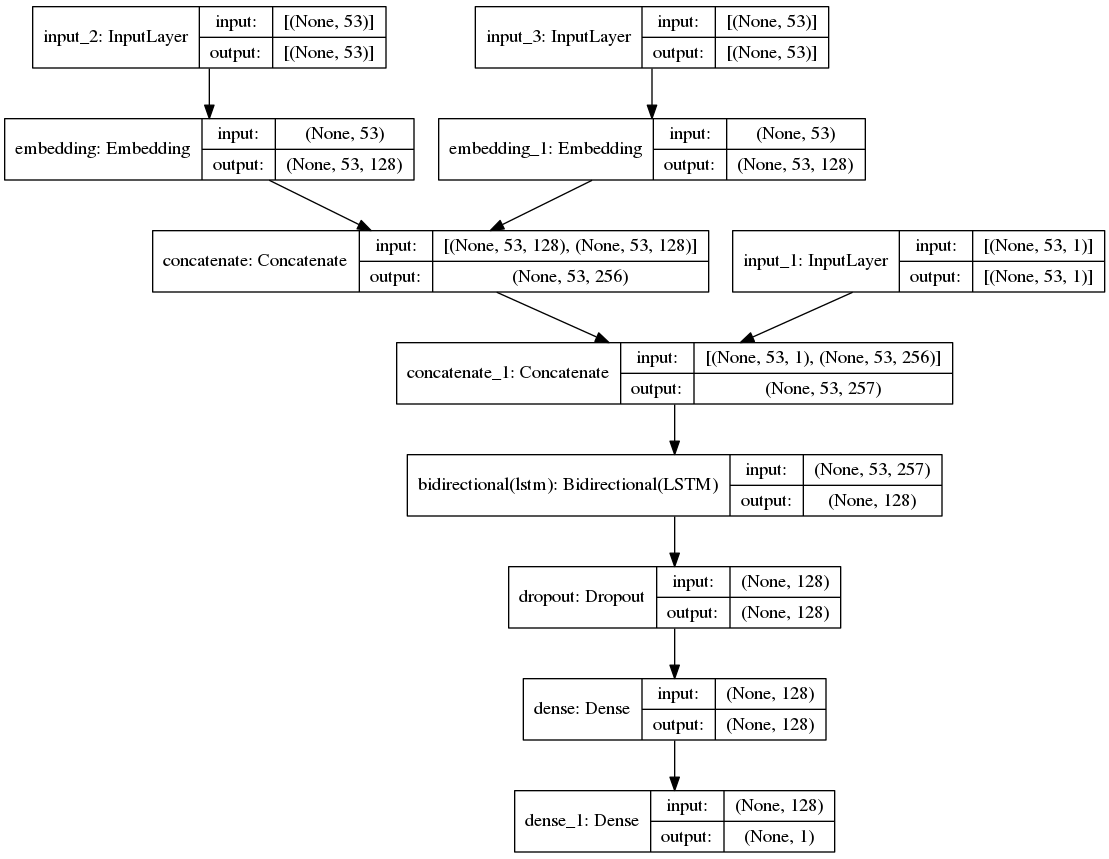

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)